In [4]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = CIFAR10('./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
data = next(iter(trainloader))

Files already downloaded and verified


Category:  0


<function matplotlib.pyplot.show(close=None, block=None)>

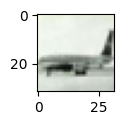

In [ ]:
train_images = data[0].numpy()
train_images = np.moveaxis(train_images, 1, 3)
train_labels = data[1].numpy()

print('Category: ', train_labels[100])
plt.figure(figsize=(1,1))
plt.imshow(train_images[100])
plt.show

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
# from utilities import train_model

In [ ]:
def train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset, optimizer, loss_function):
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    for i in range(EPOCHS):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_batches = 0
        for inputs, targets in trainloader:
            one_hot_targets = nn.functional.one_hot(targets, num_classes=10).float()
            inputs, targets, one_hot_targets = inputs.to(device), targets.to(device), one_hot_targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, one_hot_targets)

            _, indices = torch.max(outputs.data, 1)
            train_correct += (indices == targets).sum().item()
            train_batches += 1
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        train_loss = train_loss / train_batches
        train_acc = train_correct / (train_batches * BATCH_SIZE)

        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_batches = 0
        for inputs, targets in testloader:
            one_hot_targets = nn.functional.one_hot(targets, num_classes=10).float()
            inputs, targets, one_hot_targets = inputs.to(device), targets.to(device), one_hot_targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, one_hot_targets)
            _, indices = torch.max(outputs.data, 1)
            test_correct += (indices == targets).sum().item()
            test_batches += 1
            test_loss += loss.item()

        test_loss = test_loss / test_batches
        test_acc = test_correct / (test_batches * BATCH_SIZE)

        print(f"EPOCH {i+1}/{EPOCHS} LOSS: {train_loss:.4f} - ACC: {train_acc:.4f} - VAL_LOSS: {test_loss:.4f} - VAL_ACC: {test_acc:.4f}")


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 32
BATCH_SIZE = 32

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)
data = next(iter(trainloader))
mean = data[0].mean()
stddev = data[0].std()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, stddev)])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 64, 5, stride=2, padding=2),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64*8*8,10)
)

layers = next(model.modules())
conv_layer0 = layers[0]
conv_layer1 = layers[2]
output_layer = layers[5]

In [ ]:
nn.init.kaiming_normal_(conv_layer0.weight)
nn.init.constant_(conv_layer0.bias, 0.0)
nn.init.kaiming_normal_(conv_layer1.weight)
nn.init.constant_(conv_layer1.bias, 0.0)

In [ ]:
nn.init.xavier_uniform_(output_layer.weight)
nn.init.constant_(output_layer.bias, 0.0)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()

In [ ]:
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset, optimizer, loss_function, 'acc')